In [1]:
print('hello world')

hello world


In [36]:
rm -rf /kaggle/working/state.db

In [3]:
import os
import shutil
import yaml

# === Đọc file data.yaml ===
with open("/kaggle/input/drowsy-3-classes-yolo/data.yaml", "r") as f:
    data_cfg = yaml.safe_load(f)

class_names = data_cfg["names"]  # là list: ['drowsy', 'normal', 'yawning']

splits = {
    "train": os.path.join("/kaggle/input/drowsy-3-classes-yolo", "train"),
    "val": os.path.join("/kaggle/input/drowsy-3-classes-yolo", "valid"),
    "test": os.path.join("/kaggle/input/drowsy-3-classes-yolo", "test")
}

output_root = "/kaggle/working/drowsy"

def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def process_split(split_name, split_path):
    img_dir = os.path.join(split_path, "images")
    lbl_dir = os.path.join(split_path, "labels")

    for label_file in os.listdir(lbl_dir):
        if not label_file.endswith(".txt"):
            continue

        with open(os.path.join(lbl_dir, label_file), "r") as f:
            lines = f.readlines()

        if not lines:
            continue

        class_id = int(lines[0].split()[0])
        class_name = class_names[class_id]  # SỬ DỤNG DẠNG MẢNG

        img_name = label_file.replace(".txt", ".jpg")
        src_img_path = os.path.join(img_dir, img_name)

        if not os.path.exists(src_img_path):
            continue

        dst_dir = os.path.join(output_root, split_name, class_name)
        create_folder(dst_dir)

        shutil.copy2(src_img_path, os.path.join(dst_dir, img_name))
        print(f"{split_name}/{img_name} -> {class_name}")

# Chạy
for split_name, split_path in splits.items():
    process_split(split_name, split_path)

print("✅ Done: dữ liệu đã được chuyển sang dạng ImageFolder")


train/WIN_20231015_15_57_47_Pro_mp4-55_jpg.rf.d4f4cdeda40179e976135171820a0eba.jpg -> Drowsy
train/22-09-23_mp4-585_jpg.rf.82bb197512f9af60511e40c905480c05.jpg -> Yawning
train/22-09-23_mp4-1133_jpg.rf.05fa89f22d5db679a2990ce716c68c22.jpg -> Yawning
train/22-09-23_mp4-2171_jpg.rf.4db46030fdc3407872710c856e541603.jpg -> Nondrowsy
train/22-09-23_mp4-263_jpg.rf.bf802879a1ae619c8aa433e87e28f54a.jpg -> Nondrowsy
train/_import_6211ce10da1d25_07242236_preview_mp4-57_jpg.rf.ec3fb0e366d214bd134403eae9f31dfb.jpg -> Drowsy
train/2023-09-22-17-51-12_mp4-407_jpg.rf.bd191cd7147dc983bd12dfe7cb0b573f.jpg -> Nondrowsy
train/P1042762_720_mp4-700_jpg.rf.03205f17f8bfba998d43a796d72a1efa.jpg -> Nondrowsy
train/videoplayback_mp4-45_jpg.rf.314a850c5b494f2b001e9324b4d23d1f.jpg -> Yawning
train/P1042793_720_mp4-323_jpg.rf.7d25a11399f533230f0c43c2cf98def9.jpg -> Nondrowsy
train/2023-09-22-17-51-12_mp4-122_jpg.rf.f614e2af8ae264a44bd32c4b267958d8.jpg -> Drowsy
train/P1042762_720_mp4-105_jpg.rf.20d0b157e8acf3a10e2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel, DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
from transformers import ViTModel, ViTConfig
import cv2
import numpy as np
from PIL import Image
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import torch.distributed as dist
import torch.multiprocessing as mp

In [2]:
class ViTForDrowsinessDetection(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ViTForDrowsinessDetection, self).__init__()
        
        if pretrained:
            self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        else:
            config = ViTConfig(
                image_size=224,
                patch_size=16,
                num_channels=3,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12
            )
            self.vit = ViTModel(config)
        
        # Thay thế Sequential bằng các layer riêng biệt
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.vit.config.hidden_size, 512)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Khởi tạo weights
        self._init_weights()
        
    def _init_weights(self):
        """Khởi tạo weights cho các layer mới"""
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
        
    def forward(self, pixel_values):
        # Forward pass qua ViT
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output  # [batch_size, hidden_size]
        
        # Forward pass qua classification head
        x = self.dropout1(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        logits = self.fc2(x)
        
        return logits
    
    def get_features(self, pixel_values):
        """Trích xuất features từ ViT backbone"""
        with torch.no_grad():
            outputs = self.vit(pixel_values=pixel_values)
            return outputs.pooler_output

In [3]:
class DrowsinessDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths: List of paths to images
            labels: List of labels (0: drowsy, 1: yawn, 2: non-drowsy)
            transform: torchvision transforms
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Label mapping
        self.label_to_idx = {
            'Drowsy': 0,
            'Nondrowsy': 1, 
            'Yawning': 2
        }
        
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            # Load image với error handling
            image_path = self.image_paths[idx]
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image not found: {image_path}")
                
            image = Image.open(image_path).convert('RGB')
            
            # Get label
            if isinstance(self.labels[idx], str):
                label = self.label_to_idx[self.labels[idx]]
            else:
                label = self.labels[idx]
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
                
            return image, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            print(f"Error loading image {idx}: {e}")
            # Return a dummy sample
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, torch.tensor(0, dtype=torch.long)

In [4]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1)
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

In [5]:
def load_dataset_from_folders(data_dir):
    """
    Load dataset từ folder có sẵn với validation
    """
    train_paths, train_labels = [], []
    val_paths, val_labels = [], []
    
    # Load training data
    train_dir = os.path.join(data_dir, 'train')
    if os.path.exists(train_dir):
        for class_name in ['Drowsy', 'Nondrowsy', 'Yawning']:
            class_dir = os.path.join(train_dir, class_name)
            if os.path.exists(class_dir):
                valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(valid_extensions):
                        img_path = os.path.join(class_dir, img_name)
                        if os.path.getsize(img_path) > 0:  # Check file size
                            train_paths.append(img_path)
                            train_labels.append(class_name)
    
    # Load validation data
    val_dir = os.path.join(data_dir, 'val')
    if os.path.exists(val_dir):
        for class_name in ['Drowsy', 'Nondrowsy', 'Yawning']:
            class_dir = os.path.join(val_dir, class_name)
            if os.path.exists(class_dir):
                valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(valid_extensions):
                        img_path = os.path.join(class_dir, img_name)
                        if os.path.getsize(img_path) > 0:  # Check file size
                            val_paths.append(img_path)
                            val_labels.append(class_name)
    
    return train_paths, train_labels, val_paths, val_labels

In [6]:
def setup_multi_gpu_dataparallel(model, device_ids=None):
    """Setup multi-GPU với DataParallel"""
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f'Found {num_gpus} GPU(s)')
        
        if device_ids is None:
            device_ids = list(range(num_gpus))
            
        for i in device_ids:
            print(f'GPU {i}: {torch.cuda.get_device_name(i)}')
            
        if num_gpus > 1:
            model = DataParallel(model, device_ids=device_ids)
            print(f'Using DataParallel with GPUs: {device_ids}')
        else:
            print('Only 1 GPU available, using single GPU training')
            
        return model, device_ids[0] if device_ids else 0
    else:
        print('No GPU available, using CPU')
        return model, 'cpu'

In [7]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        logprobs = torch.nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [37]:
def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda', use_mixed_precision=True):
    # Loss function với label smoothing
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    
    # # Optimizer với weight decay
    # optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01, 
    #                        betas=(0.9, 0.999), eps=1e-8)
    
    # # Learning rate scheduler
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    #     optimizer, T_0=10, T_mult=2, eta_min=1e-6
    # )
    
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                    patience=5, factor=0.5)
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    save_dir = '/kaggle/working/models'
    os.makedirs(save_dir, exist_ok=True)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 10
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            if use_mixed_precision and scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_acc = 100. * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })
            
            # Gradient clipping để tránh exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        train_acc = 100. * train_correct / train_total
        train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                if use_mixed_precision:
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                current_acc = 100. * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })
        
        val_acc = 100. * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.2e}')
        print('-' * 60)
        
        # Early stopping và save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            
            # Save model state
            model_state = model.module.state_dict() if isinstance(model, DataParallel) else model.state_dict()
            model_path = os.path.join(save_dir, 'best_vit_drowsiness_model.pth')
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'train_loss': train_loss,
            }, model_path)
            print(f'✅ New best model saved! Val Acc: {val_acc:.2f}%')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping after {patience} epochs without improvement')
            break
    
    return train_losses, val_losses, train_accs, val_accs

In [9]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(train_accs, label='Train Accuracy', color='blue', linewidth=2)
    ax2.plot(val_accs, label='Validation Accuracy', color='red', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Classification report
    class_names = ['drowsy', 'yawn', 'non-drowsy']
    report = classification_report(all_labels, all_preds, 
                                 target_names=class_names, 
                                 output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Test Accuracy: {accuracy*100:.2f}%')
    print(f'Per-class Accuracy:')
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i].sum() * 100
        print(f'   {class_name}: {class_acc:.2f}%')
    
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontsize=12,
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, report

In [11]:
def predict_single_image(model, image_path, device='cuda'):
    """Predict drowsiness cho 1 ảnh"""
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    _, transform = get_transforms()
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        if isinstance(model, DataParallel):
            outputs = model.module(image_tensor)
        else:
            outputs = model(image_tensor)
            
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    class_names = ['Drowsy', 'Nondrowsy', 'Yawning']
    predicted_label = class_names[predicted_class]
    
    return predicted_label, confidence, probabilities[0].cpu().numpy()


In [23]:
def test_inference():
    """Test inference trên một vài ảnh mẫu"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model = ViTForDrowsinessDetection(num_classes=3, pretrained=True)
    model, main_device = setup_multi_gpu_dataparallel(model)
    
    # Load trained weights
    checkpoint = torch.load('/kaggle/working/models/best_vit_drowsiness_model.pth')
    if isinstance(model, DataParallel):
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    model.to(main_device)
    
    # Test trên một vài ảnh
    test_images = ['/kaggle/working/drowsy/test/Drowsy/2023-09-22-12-05-19_mp4-236_jpg.rf.03e8121a32e22380988c7942b4ca5e5f.jpg', 
                   '/kaggle/working/drowsy/test/Nondrowsy/22-09-23_mp4-201_jpg.rf.4824fca5ecd5480daedb3bdbcbbe4f6b.jpg', 
                   '/kaggle/working/drowsy/test/Yawning/22-09-23_mp4-1273_jpg.rf.51925d496d18ee9f728c3940bce8c954.jpg'] 
    
    for img_path in test_images:
        if os.path.exists(img_path):
            pred_label, confidence, probs = predict_single_image(model, img_path, main_device)
            print(f'Image: {img_path}')
            print(f'Prediction: {pred_label} (confidence: {confidence:.3f})')
            print(f'Probabilities: drowsy={probs[0]:.3f}, yawn={probs[1]:.3f}, non-drowsy={probs[2]:.3f}')
            print('-' * 50)


Using device: cuda
Training samples: 12486
Validation samples: 1190

Training class distribution:
  Drowsy: 3180 samples
  Nondrowsy: 5373 samples
  Yawning: 3933 samples


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2873611642.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None


Found 2 GPU(s)
GPU 0: Tesla T4
GPU 1: Tesla T4
Using DataParallel with GPUs: [0, 1]
🔧 Total parameters: 86,784,515
🔧 Trainable parameters: 86,784,515

Starting training...


Epoch 1/50 - Training:   0%|          | 0/195 [00:00<?, ?it/s]/tmp/ipykernel_35/2873611642.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 - Validation:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_35/2873611642.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s, Loss=0.3327, Acc=91.43%]



Epoch 1/50:
Train Loss: 0.5460, Train Acc: 85.46%
Val Loss: 0.4463, Val Acc: 91.43%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 91.43%


Epoch 2/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.88it/s, Loss=0.3263, Acc=91.26%]



Epoch 2/50:
Train Loss: 0.4630, Train Acc: 90.53%
Val Loss: 0.4413, Val Acc: 91.26%
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 3/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s, Loss=0.3053, Acc=91.76%]



Epoch 3/50:
Train Loss: 0.4435, Train Acc: 91.92%
Val Loss: 0.4367, Val Acc: 91.76%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 91.76%


Epoch 4/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s, Loss=0.3131, Acc=89.24%]



Epoch 4/50:
Train Loss: 0.4303, Train Acc: 92.38%
Val Loss: 0.4894, Val Acc: 89.24%
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 5/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s, Loss=0.3590, Acc=92.35%]



Epoch 5/50:
Train Loss: 0.4257, Train Acc: 92.74%
Val Loss: 0.4246, Val Acc: 92.35%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 92.35%


Epoch 6/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s, Loss=0.3182, Acc=92.61%]



Epoch 6/50:
Train Loss: 0.4158, Train Acc: 93.16%
Val Loss: 0.4356, Val Acc: 92.61%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 92.61%


Epoch 7/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s, Loss=0.3415, Acc=93.19%]



Epoch 7/50:
Train Loss: 0.4115, Train Acc: 93.45%
Val Loss: 0.4197, Val Acc: 93.19%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 93.19%


Epoch 8/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.92it/s, Loss=0.3356, Acc=93.61%]



Epoch 8/50:
Train Loss: 0.4050, Train Acc: 93.89%
Val Loss: 0.4120, Val Acc: 93.61%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 93.61%


Epoch 9/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s, Loss=0.3053, Acc=93.78%]



Epoch 9/50:
Train Loss: 0.4015, Train Acc: 94.13%
Val Loss: 0.4071, Val Acc: 93.78%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 93.78%


Epoch 10/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s, Loss=0.3482, Acc=92.69%]



Epoch 10/50:
Train Loss: 0.3992, Train Acc: 94.14%
Val Loss: 0.4263, Val Acc: 92.69%
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 11/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s, Loss=0.3598, Acc=93.03%]



Epoch 11/50:
Train Loss: 0.3934, Train Acc: 94.42%
Val Loss: 0.4242, Val Acc: 93.03%
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 12/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s, Loss=0.3577, Acc=92.10%]



Epoch 12/50:
Train Loss: 0.3960, Train Acc: 94.25%
Val Loss: 0.4330, Val Acc: 92.10%
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 13/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s, Loss=0.3108, Acc=93.95%]



Epoch 13/50:
Train Loss: 0.3890, Train Acc: 94.52%
Val Loss: 0.4089, Val Acc: 93.95%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 93.95%


Epoch 14/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.85it/s, Loss=0.3105, Acc=94.37%]



Epoch 14/50:
Train Loss: 0.3872, Train Acc: 94.71%
Val Loss: 0.4080, Val Acc: 94.37%
Learning Rate: 1.00e-04
------------------------------------------------------------
✅ New best model saved! Val Acc: 94.37%


Epoch 15/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.85it/s, Loss=0.3134, Acc=93.11%]



Epoch 15/50:
Train Loss: 0.3853, Train Acc: 94.78%
Val Loss: 0.4176, Val Acc: 93.11%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 16/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.82it/s, Loss=0.3529, Acc=92.02%]



Epoch 16/50:
Train Loss: 0.3716, Train Acc: 95.71%
Val Loss: 0.4463, Val Acc: 92.02%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 17/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s, Loss=0.3019, Acc=93.53%]



Epoch 17/50:
Train Loss: 0.3660, Train Acc: 95.83%
Val Loss: 0.4042, Val Acc: 93.53%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 18/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s, Loss=0.3001, Acc=93.45%]



Epoch 18/50:
Train Loss: 0.3671, Train Acc: 95.75%
Val Loss: 0.4120, Val Acc: 93.45%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 19/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.79it/s, Loss=0.3005, Acc=94.37%]



Epoch 19/50:
Train Loss: 0.3617, Train Acc: 96.32%
Val Loss: 0.4080, Val Acc: 94.37%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 20/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.85it/s, Loss=0.3596, Acc=94.12%]



Epoch 20/50:
Train Loss: 0.3616, Train Acc: 96.14%
Val Loss: 0.4087, Val Acc: 94.12%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 21/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.92it/s, Loss=0.3332, Acc=94.71%]



Epoch 21/50:
Train Loss: 0.3594, Train Acc: 96.47%
Val Loss: 0.3919, Val Acc: 94.71%
Learning Rate: 5.00e-05
------------------------------------------------------------
✅ New best model saved! Val Acc: 94.71%


Epoch 22/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s, Loss=0.3493, Acc=94.03%]



Epoch 22/50:
Train Loss: 0.3604, Train Acc: 96.06%
Val Loss: 0.4056, Val Acc: 94.03%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 23/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.77it/s, Loss=0.3429, Acc=94.96%]



Epoch 23/50:
Train Loss: 0.3548, Train Acc: 96.67%
Val Loss: 0.3934, Val Acc: 94.96%
Learning Rate: 5.00e-05
------------------------------------------------------------
✅ New best model saved! Val Acc: 94.96%


Epoch 24/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s, Loss=0.3003, Acc=94.62%]



Epoch 24/50:
Train Loss: 0.3629, Train Acc: 95.99%
Val Loss: 0.4027, Val Acc: 94.62%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 25/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.92it/s, Loss=0.3463, Acc=94.71%]



Epoch 25/50:
Train Loss: 0.3561, Train Acc: 96.63%
Val Loss: 0.3970, Val Acc: 94.71%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 26/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s, Loss=0.3446, Acc=94.79%]



Epoch 26/50:
Train Loss: 0.3524, Train Acc: 96.73%
Val Loss: 0.4003, Val Acc: 94.79%
Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch 27/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s, Loss=0.3631, Acc=93.70%]



Epoch 27/50:
Train Loss: 0.3546, Train Acc: 96.53%
Val Loss: 0.4099, Val Acc: 93.70%
Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch 28/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.92it/s, Loss=0.3394, Acc=94.45%]



Epoch 28/50:
Train Loss: 0.3486, Train Acc: 96.80%
Val Loss: 0.4012, Val Acc: 94.45%
Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch 29/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s, Loss=0.3277, Acc=94.79%]



Epoch 29/50:
Train Loss: 0.3446, Train Acc: 97.20%
Val Loss: 0.3942, Val Acc: 94.79%
Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch 30/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s, Loss=0.3052, Acc=94.87%]



Epoch 30/50:
Train Loss: 0.3426, Train Acc: 97.20%
Val Loss: 0.3956, Val Acc: 94.87%
Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch 31/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s, Loss=0.3483, Acc=94.29%]



Epoch 31/50:
Train Loss: 0.3432, Train Acc: 97.13%
Val Loss: 0.4102, Val Acc: 94.29%
Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch 32/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.92it/s, Loss=0.3055, Acc=94.79%]



Epoch 32/50:
Train Loss: 0.3427, Train Acc: 97.32%
Val Loss: 0.4001, Val Acc: 94.79%
Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch 33/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s, Loss=0.3194, Acc=95.29%]



Epoch 33/50:
Train Loss: 0.3432, Train Acc: 97.08%
Val Loss: 0.3938, Val Acc: 95.29%
Learning Rate: 1.25e-05
------------------------------------------------------------
✅ New best model saved! Val Acc: 95.29%


Epoch 34/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s, Loss=0.3090, Acc=94.87%]



Epoch 34/50:
Train Loss: 0.3394, Train Acc: 97.38%
Val Loss: 0.3963, Val Acc: 94.87%
Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch 35/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s, Loss=0.3158, Acc=95.04%]



Epoch 35/50:
Train Loss: 0.3333, Train Acc: 97.79%
Val Loss: 0.3975, Val Acc: 95.04%
Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch 36/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s, Loss=0.3447, Acc=94.79%]



Epoch 36/50:
Train Loss: 0.3356, Train Acc: 97.64%
Val Loss: 0.3971, Val Acc: 94.79%
Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch 37/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.88it/s, Loss=0.3392, Acc=94.96%]



Epoch 37/50:
Train Loss: 0.3381, Train Acc: 97.39%
Val Loss: 0.3951, Val Acc: 94.96%
Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch 38/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s, Loss=0.3232, Acc=95.21%]



Epoch 38/50:
Train Loss: 0.3347, Train Acc: 97.59%
Val Loss: 0.3922, Val Acc: 95.21%
Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch 39/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s, Loss=0.3279, Acc=94.96%]



Epoch 39/50:
Train Loss: 0.3353, Train Acc: 97.72%
Val Loss: 0.4035, Val Acc: 94.96%
Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch 40/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s, Loss=0.3264, Acc=95.21%]



Epoch 40/50:
Train Loss: 0.3326, Train Acc: 97.64%
Val Loss: 0.3944, Val Acc: 95.21%
Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch 41/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s, Loss=0.3189, Acc=94.96%]



Epoch 41/50:
Train Loss: 0.3299, Train Acc: 97.81%
Val Loss: 0.4026, Val Acc: 94.96%
Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch 42/50 - Validation: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s, Loss=0.3370, Acc=95.13%]



Epoch 42/50:
Train Loss: 0.3332, Train Acc: 97.64%
Val Loss: 0.4029, Val Acc: 95.13%
Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch 43/50 - Validation: 100%|██████████| 19/19 [00:10<00:00,  1.90it/s, Loss=0.3442, Acc=94.71%]



Epoch 43/50:
Train Loss: 0.3321, Train Acc: 97.81%
Val Loss: 0.4017, Val Acc: 94.71%
Learning Rate: 6.25e-06
------------------------------------------------------------
Early stopping after 10 epochs without improvement


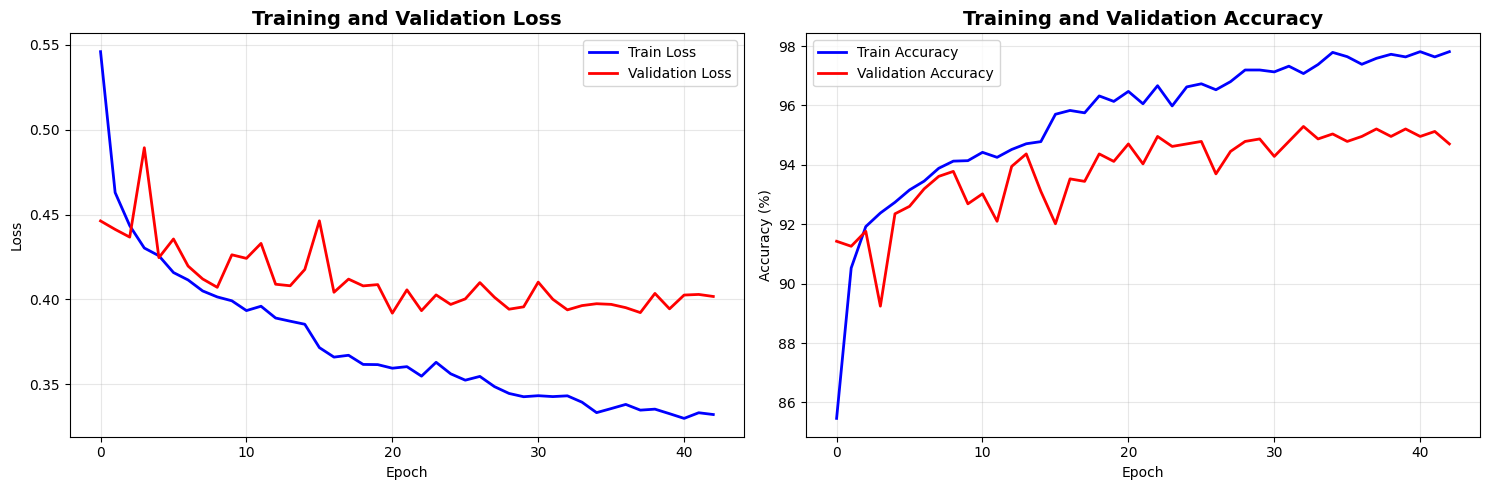


Loading best model for final evaluation...


Evaluating: 100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Test Accuracy: 95.29%
Per-class Accuracy:
   drowsy: 88.93%
   yawn: 97.21%
   non-drowsy: 97.31%

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.97      0.89      0.93       280
        yawn       0.94      0.97      0.96       538
  non-drowsy       0.97      0.97      0.97       372

    accuracy                           0.95      1190
   macro avg       0.96      0.94      0.95      1190
weighted avg       0.95      0.95      0.95      1190



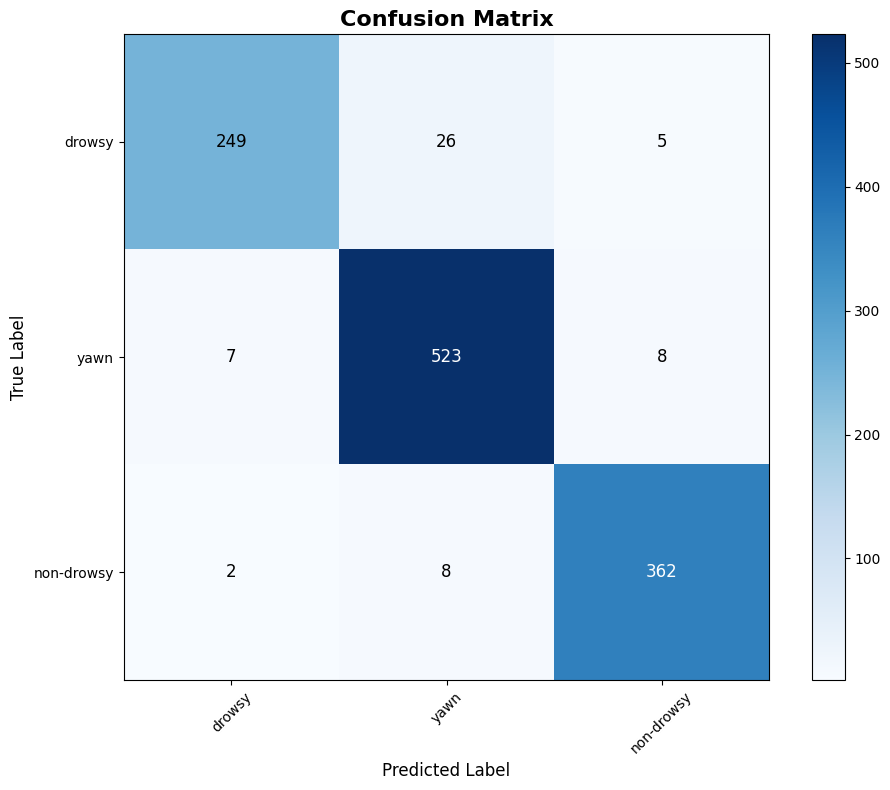

Training completed! Results saved to training_results.json
Best validation accuracy: 95.29%
Final test accuracy: 95.29%
GPU 0 Memory - Allocated: 6.03GB, Reserved: 6.65GB
GPU 1 Memory - Allocated: 2.75GB, Reserved: 3.40GB


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 2 GPU(s)
GPU 0: Tesla T4
GPU 1: Tesla T4
Using DataParallel with GPUs: [0, 1]
Image: /kaggle/working/drowsy/test/Drowsy/2023-09-22-12-05-19_mp4-236_jpg.rf.03e8121a32e22380988c7942b4ca5e5f.jpg
Prediction: Drowsy (confidence: 0.923)
Probabilities: drowsy=0.923, yawn=0.037, non-drowsy=0.041
--------------------------------------------------
Image: /kaggle/working/drowsy/test/Nondrowsy/22-09-23_mp4-201_jpg.rf.4824fca5ecd5480daedb3bdbcbbe4f6b.jpg
Prediction: Nondrowsy (confidence: 0.926)
Probabilities: drowsy=0.034, yawn=0.926, non-drowsy=0.040
--------------------------------------------------
Image: /kaggle/working/drowsy/test/Yawning/22-09-23_mp4-1273_jpg.rf.51925d496d18ee9f728c3940bce8c954.jpg
Prediction: Yawning (confidence: 0.931)
Probabilities: drowsy=0.044, yawn=0.025, non-drowsy=0.931
--------------------------------------------------


In [38]:
def main():
    # Thiết lập CUDA
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # THAY ĐỔI PATH NÀY THEO DATASET CỦA BẠN
    data_dir = '/kaggle/working/drowsy'  # Đổi thành path dataset trên Kaggle
    
    # Load dataset
    try:
        train_paths, train_labels, val_paths, val_labels = load_dataset_from_folders(data_dir)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    
    if len(train_paths) == 0:
        print("No training data found! Please check your dataset path.")
        return
        
    print(f'Training samples: {len(train_paths)}')
    print(f'Validation samples: {len(val_paths)}')
    
    # Print class distribution
    print('\nTraining class distribution:')
    from collections import Counter
    train_counts = Counter(train_labels)
    for class_name, count in train_counts.items():
        print(f'  {class_name}: {count} samples')
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = DrowsinessDataset(train_paths, train_labels, train_transform)
    val_dataset = DrowsinessDataset(val_paths, val_labels, val_transform)
    
    # Create data loaders với tối ưu cho multi-GPU
    batch_size = 64  # Tăng batch size cho multi-GPU
    num_workers = 4
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    # Create model
    model = ViTForDrowsinessDetection(num_classes=3, pretrained=True)
    
    # Setup multi-GPU
    model, main_device = setup_multi_gpu_dataparallel(model)
    model.to(main_device)
    
    # Print model info
    if isinstance(model, DataParallel):
        total_params = sum(p.numel() for p in model.module.parameters())
        trainable_params = sum(p.numel() for p in model.module.parameters() if p.requires_grad)
    else:
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
    print(f'🔧 Total parameters: {total_params:,}')
    print(f'🔧 Trainable parameters: {trainable_params:,}')
    
    # Train model
    print('\nStarting training...')
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, num_epochs=50, device=main_device, use_mixed_precision=True
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
    
    # Load best model for evaluation
    print('\nLoading best model for final evaluation...')
    checkpoint = torch.load('/kaggle/working/models/best_vit_drowsiness_model.pth')
    
    if isinstance(model, DataParallel):
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    # Evaluate on test set
    accuracy, report = evaluate_model(model, val_loader, main_device)
    
    # Save final results
    results = {
        'final_accuracy': accuracy,
        'best_val_accuracy': max(val_accs),
        'classification_report': report,
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs
        },
        'model_info': {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'num_gpus_used': torch.cuda.device_count() if torch.cuda.is_available() else 0
        }
    }
    
    with open('training_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print('Training completed! Results saved to training_results.json')
    print(f'Best validation accuracy: {max(val_accs):.2f}%')
    print(f'Final test accuracy: {accuracy*100:.2f}%')
    
    # GPU memory usage
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            memory_allocated = torch.cuda.memory_allocated(i) / 1024**3
            memory_reserved = torch.cuda.memory_reserved(i) / 1024**3
            print(f'GPU {i} Memory - Allocated: {memory_allocated:.2f}GB, Reserved: {memory_reserved:.2f}GB')

    test_inference()

if __name__ == '__main__':
    main()
    
    # Uncomment để test inference
    # test_inference()